# Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device {device}")

Working on device cpu


# Load dataset

In [2]:
# Transform image to 1x784 and normalize colors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
trainset = datasets.MNIST('dataset', download=False, train=True, transform=transform)
valset_full = datasets.MNIST('dataset', download=False, train=False, transform=transform)

val_size, test_size = 1000, 9000
val_dataset, test_dataset = torch.utils.data.random_split(valset_full, [val_size, test_size], generator=torch.Generator().manual_seed(27))

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2000, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


# for idx, (data, target) in enumerate(trainloader):
#     data = data.to(device)
#     target = target.to(device)

# for idx, (data, target) in enumerate(valloader):
#     data = data.to(device)
#     target = target.to(device)    

# Preliminary computation

In [32]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    # def __init__(self, dropout):
    def __init__(self):
        super().__init__()
        # self.dropout = nn.Dropout(dropout)
        self.soft_max = nn.Softmax(dim=2)
        
    # Shape of queries: (batch_size, img-height, d)
    # Shape of keys: (batch_size, img-height, d)
    # Shape of values: (batch_size, img-height, value dimension)
    def forward(self, queries, keys, values):
        d = queries.shape[2]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(d)
        self.attention_weights = self.soft_max(scores)
        # return torch.bmm(self.dropout(self.attention_weights), values)
        return torch.bmm(self.attention_weights, values)

class SDPA_2H_seq_NN(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(SDPA_2H_seq_NN, self).__init__()
        # d_model = input_size
        
        self.W_q1 = nn.Linear(input_size, input_size, device=device)
        self.W_k1 = nn.Linear(input_size, input_size, device=device)
        self.W_v1 = nn.Linear(input_size, input_size, device=device)
        
        d_model = input_size
        self.W_q2 = nn.Linear(input_size, d_model, device=device)
        self.W_k2 = nn.Linear(input_size, d_model, device=device)
        self.W_v2 = nn.Linear(input_size, d_model, device=device)
        
        self.W_o = nn.Linear(input_size*d_model, num_classes, device=device)
        
        self.num_classes = num_classes
        
        self.SDPA_h1 = DotProductAttention()
        self.SDPA_h2 = DotProductAttention()

        self.log_softmax = nn.LogSoftmax(dim=1)

        self.BN1 = nn.BatchNorm2d(1)
        self.BN2 = nn.BatchNorm2d(1)
        
        nn.init.xavier_uniform_(self.W_q1.weight)
        nn.init.xavier_uniform_(self.W_k1.weight)
        nn.init.xavier_uniform_(self.W_v1.weight)
        nn.init.xavier_uniform_(self.W_q2.weight)
        nn.init.xavier_uniform_(self.W_k2.weight)
        nn.init.xavier_uniform_(self.W_v2.weight)
        nn.init.xavier_uniform_(self.W_o.weight)

    def forward(self, x):
        # Multiply input by weights and add biases
        
        Q1 = self.W_q1(x)
        K1 = self.W_k1(x)
        V1 = self.W_v1(x)
        
        sdpa_out = self.SDPA_h1(Q1, K1, V1)
        out = self.BN1(sdpa_out.unsqueeze(1) + x.unsqueeze(1))
        out = out.squeeze(1)
        
        Q2 = self.W_q2(out)
        K2 = self.W_k2(out)
        V2 = self.W_v2(out)
        
        sdpa_out = self.SDPA_h2(Q2, K2, V2)
        out = self.BN2(sdpa_out.unsqueeze(1) + out.unsqueeze(1) )
        out = out.squeeze(1)
        
        out = out.reshape(out.shape[0],-1)
        
        out = self.log_softmax(self.W_o(out))
        
        return out
    
    # def get_matricies(self, x):
    #     Q = self.W_q(x)
    #     K = self.W_k(x)
    #     V = self.W_v(x)
    #     y = self.SDPA(Q, K, V)

    #     return Q,K,V,y,self.SDPA.attention_weights

# Train loop

In [49]:
# Build the Neural Network
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

N_epoch = 240
d1,d2=input_size,input_size
model = SDPA_2H_seq_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\SDPA_2H_seq_d{d1}-d{d2}_NN_epoch_{N_epoch}.pth', map_location=torch.device('cpu'))) #
# print(model)
model.to(device)

# criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss which includes softmax
criterion = nn.NLLLoss()  # Use CrossEntropyLoss which includes softmax
optimizer = optim.Adam(model.parameters(), lr=12e-4, weight_decay=10e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.96, verbose=False)

# Track loss
loss_list = []
val_loss_list = []

# Training the network
epochs = 30
time0 = time()

for epoch in range(epochs):
    running_loss = 0

    # for images, labels in tqdm(trainloader, leave=False):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.squeeze(1)                 

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)               
        
        # This is where the model learns by back propagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
    
    # validation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.squeeze(1)                 
            
            output = model(images)
            val_loss = criterion(output, labels)
    val_loss = val_loss / len(val_loader)
    val_loss_list.append(val_loss)
        
    CE_curr = running_loss / len(trainloader)
    loss_list.append(CE_curr)
    # if (epoch%10)==0:
    print(f"Epoch {epoch} - Training loss: {CE_curr:.5f}, Val loss: {val_loss:.5f}")
    
    
print(f"\nTraining Time (in minutes) = {(time()-time0)/60:.2f}")

# Convert lists to numpy arrays
loss_array = np.array(loss_list)

val_loss = [val.cpu().numpy() for val in val_loss_list]

val_loss_array = np.array(val_loss)

# Save the model
torch.save(model.state_dict(), f'model_backup\SDPA_2H_seq_d{d1}-d{d2}_NN_epoch_{N_epoch+epochs}.pth')

Epoch 0 - Training loss: 0.08564, Val loss: 0.12101
Epoch 1 - Training loss: 0.07863, Val loss: 0.11981
Epoch 2 - Training loss: 0.07696, Val loss: 0.11923
Epoch 3 - Training loss: 0.07574, Val loss: 0.11782
Epoch 4 - Training loss: 0.07455, Val loss: 0.11661
Epoch 5 - Training loss: 0.07369, Val loss: 0.11952
Epoch 6 - Training loss: 0.07233, Val loss: 0.11609
Epoch 7 - Training loss: 0.07186, Val loss: 0.12063
Epoch 8 - Training loss: 0.07095, Val loss: 0.11760
Epoch 9 - Training loss: 0.07064, Val loss: 0.11725
Epoch 10 - Training loss: 0.06983, Val loss: 0.11747
Epoch 11 - Training loss: 0.06965, Val loss: 0.11970
Epoch 12 - Training loss: 0.06907, Val loss: 0.11907
Epoch 13 - Training loss: 0.06828, Val loss: 0.11564
Epoch 14 - Training loss: 0.06784, Val loss: 0.11589
Epoch 15 - Training loss: 0.06732, Val loss: 0.11615
Epoch 16 - Training loss: 0.06748, Val loss: 0.11540
Epoch 17 - Training loss: 0.06672, Val loss: 0.11759
Epoch 18 - Training loss: 0.06687, Val loss: 0.11720
Epo

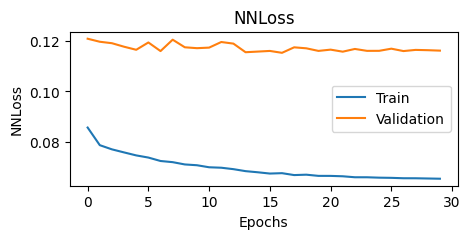

In [50]:

# # Save the model
# torch.save(model.state_dict(), f'model_backup\SDPA_2H_d10_NN_epoch_{N_epoch+epochs}.pth')

# Plot NLL_loss
plt.figure(figsize=(5, 2))
plt.plot(range(len(loss_array)), loss_array, label='Train')
plt.plot(range(len(val_loss_array)), val_loss_array, label='Validation')

plt.xlabel('Epochs')
plt.ylabel('NNLoss')
plt.title('NNLoss')
plt.legend()
plt.show()

# NN test

In [51]:
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = SDPA_2H_seq_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\SDPA_2H_seq_d{d1}-d{d2}_NN_epoch_{N_epoch+epochs}.pth', map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('model_backup\sa_NN_epoch_1000.pth'))
model.to(device)

correct = 0
total = 0

model.eval()
for X, y_true in test_loader:
    X = X.squeeze(1) 
    X = X.to(device)
    y_true = y_true.to(device)
    
    outputs = model(X)
    _,y_pred = torch.max(outputs, dim=1)
    total +=y_true.shape[0]
    correct +=int((y_pred==y_true).sum())

print(f"Accuracy = {correct/total: .3f}")

Accuracy =  0.963


# Visualization

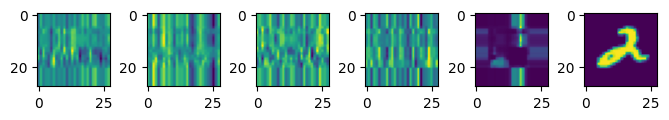

In [58]:
model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load('model_backup\sa_NN_epoch_1400.pth')) # map_location=torch.device('cpu')

img, label = trainset[693]
img = img.to(device)

Q,K,V,Y,att_weights = model.get_matricies(img)

fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=6)
plt.subplot(1,6,1)
plt.imshow(Q.squeeze(0).detach().cpu())
plt.subplot(1,6,2)
plt.imshow(K.squeeze(0).detach().cpu())
plt.subplot(1,6,3)
plt.imshow(V.squeeze(0).detach().cpu())
plt.subplot(1,6,4)
plt.imshow(Y.squeeze(0).detach().cpu())
plt.subplot(1,6,5)
plt.imshow(att_weights.squeeze(0).detach().cpu())
plt.subplot(1,6,6)
plt.imshow(img.squeeze(0).detach().cpu())

plt.subplots_adjust(wspace=0.5)